In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


<Figure size 432x288 with 0 Axes>

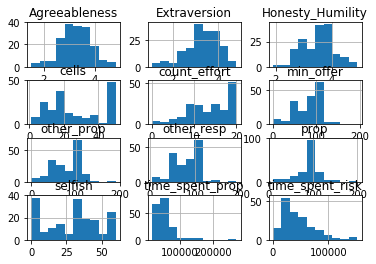

<Figure size 432x288 with 0 Axes>

In [2]:
from utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

MAX_GAIN = 200

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")

# display(df.head())
# df.hist()


In [5]:
from sklearn.linear_model import LinearRegression
from notebooks.utils.preprocessing import df_to_xy

x, y = df_to_xy(df)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)



In [9]:
from utils.data_augmentation import DACombine

Using TensorFlow backend.


In [10]:
from models.deep import keras_linear_regression, keras_model, loss_tf, gain_tf, KerasModel

**Metrics**

**AcceptanceModel**

In [ ]:
from models import AcceptanceModel

gain_mean:  83.88888888888889


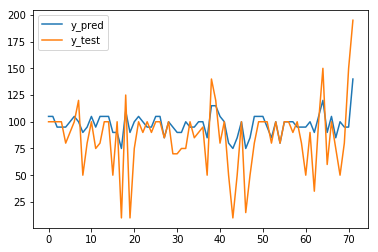

In [21]:
from sklearn.ensemble.bagging import BaggingRegressor, BaggingClassifier, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import NuSVC, SVC, LinearSVC, LinearSVR, SVR, NuSVR

#LinearSVR, zero_one=True: 87
#SVR, zero_one=True: 70

model = AcceptanceModel(LinearSVR(loss='epsilon_insensitive', ), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yTrain_[yTrain_ < 50] = 50

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

gain_mean:  83.125


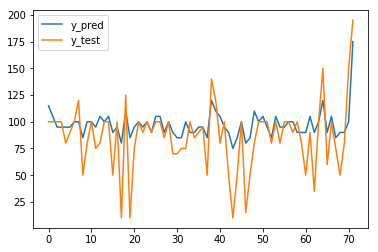

In [28]:
model = AcceptanceModel(SVR(gamma="auto"), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

gain_mean:  61.94444444444444


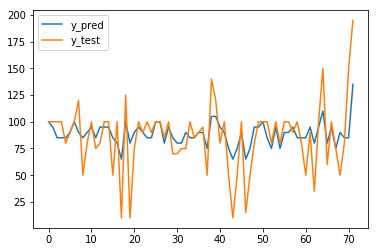

In [29]:
model = AcceptanceModel(LinearSVC(loss='epsilon_insensitive'), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


gain_mean:  85.76388888888889


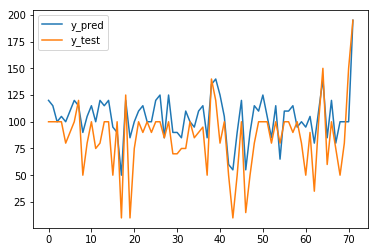

In [52]:
model = AcceptanceModel(PassiveAggressiveClassifier(), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

gain_mean:  83.05555555555556


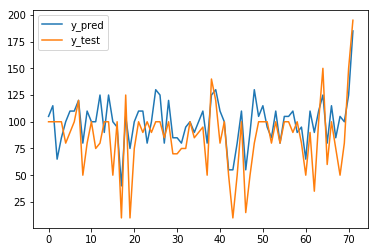

In [68]:
model = AcceptanceModel(LogisticRegression(solver='lbfgs'), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=15, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

gain_mean:  82.36111111111111


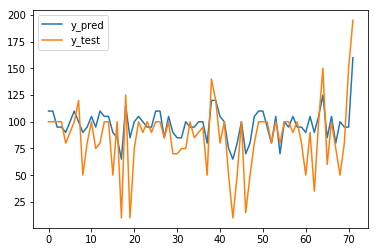

In [75]:
model = AcceptanceModel(LinearRegression(), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
model.fit(xTrain_, yTrain_.ravel())

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))